In [1]:
from code_for_hw7 import *
import numpy as np
import modules_disp as disp

In [4]:
class Linear(Module):
    """A simple, fully-connected linear layer."""

    def __init__(self, m, n):
        """Initializes the layer based on input and output dimensions. 

        Note: Kernel is initialized using normal distribution with mean 0 and 
        variance 1 / m. All biases are initialized to zero.

        Args:
            m (int): Number of inputs to the layer.
            n (int): Number of outputs from the layer.

        """
        self.m, self.n = m, n

        self.W0 = np.zeros((n, 1))
        self.W = np.random.normal(0, np.sqrt(1 / m), (m, n))

    def forward(self, A):
        """Computes the forward pass through the linear network for a batch.

        Args:
            A (ndarray): An m by b matrix representing the m activations from the
                previous layer for a batch of size b.

        Returns:
            ndarray: An n by b matrix representing the result of passing the 
                activations through the network layer for a batch of size b.

        """
        self.A = A

        return self.W.T @ self.A + self.W0

    def backward(self, dLdZ):
        """Uses the gradient of loss with respect to outputs of the layer for a 
        batch to update the sum of gradients of the loss with respect to the 
        weights for the entire batch. Also returns the gradient of the loss with 
        respect to the inputs to the layer for a batch.

        Args:
            dLdZ (ndarray): An n by b matrix representing the gradient of the loss
                with respect to the layer outputs for a batch of size b.

        Returns:
            ndarray: An m by b matrix representing the gradient of the loss with 
                respect to the inputs to the layer for a batch of size b.

        """
        self.dLdW = self.A @ dLdZ.T  # Implicit sum over all b
        self.dLdW0 = np.sum(dLdZ, axis=1, keepdims=True)

        return self.W @ dLdZ

    def sgd_step(self, lrate):
        """Performs a single step of gradient descent to update the weights for a 
        single batch of points.

        Args:
            lrate (float): A learning rate to scale the gradient for the update.

        """
        self.W = self.W - lrate * self.dLdW
        self.W0 = self.W0 - lrate * self.dLdW0

In [5]:
np.random.seed(0)

# data
X, Y = super_simple_separable()

# module
linear_1 = Linear(2, 3)

#hyperparameters
lrate = 0.005

# test case
# forward
z_1 = linear_1.forward(X)
exp_z_1 =  np.array([[10.41750064, 6.91122168, 20.73366505, 22.8912344],
                     [7.16872235, 3.48998746, 10.46996239, 9.9982611],
                     [-2.07105455, 0.69413716, 2.08241149, 4.84966811]])
unit_test("linear_forward", exp_z_1, z_1)

# backward
dL_dz1 = np.array([[1.69467553e-09, -1.33530535e-06, 0.00000000e+00, -0.00000000e+00],
                                     [-5.24547376e-07, 5.82459519e-04, -3.84805202e-10, 1.47943038e-09],
                                     [-3.47063705e-02, 2.55611604e-01, -1.83538094e-02, 1.11838432e-04]])
exp_dLdX = np.array([[-2.40194628e-02, 1.77064845e-01, -1.27021626e-02, 7.74006953e-05],
                                    [2.39827939e-02, -1.75870737e-01, 1.26832126e-02, -7.72828555e-05]])
dLdX = linear_1.backward(dL_dz1)
unit_test("linear_backward", exp_dLdX, dLdX)

# sgd step
linear_1.sgd_step(lrate)
exp_linear_1_W = np.array([[1.2473734,  0.28294514,  0.68940437],
                           [1.58455079, 1.32055711, -0.69218045]]),
unit_test("linear_sgd_step_W",  exp_linear_1_W,  linear_1.W)

exp_linear_1_W0 = np.array([[6.66805339e-09],
                            [-2.90968033e-06],
                            [-1.01331631e-03]]),
unit_test("linear_sgd_step_W0", exp_linear_1_W0, linear_1.W0)


linear_forward: OK
linear_backward: OK
linear_sgd_step_W: OK
linear_sgd_step_W0: OK


In [6]:
class Tanh(Module):
    """Hyperbolic tangent activation layer."""

    def forward(self, Z):
        """Computes the output of the hyperbolic tangent activation layer.

        Args:
            Z (ndarray): An n by b matrix representing the input pre-activations
                of the layer for a batch of size b.

        Returns:
            ndarray: An n by b matrix representing the output of the layer after
                using the hyperbolic tangent activation on all inputs for a batch
                of size b.

        """
        self.A = np.tanh(Z)

        return self.A

    def backward(self, dLdA):
        """Computes the gradient of the loss with respect to the inputs to the
        layer using the gradient of the loss with respect to the outputs of the
        layer for a single batch.

        Args:
            dLdA (ndarray): An n by b matrix representing the gradient of the loss
                with respect to the outputs for the layer for a batch of size b.

        Returns:
            ndarray: An n by b matrix representing the gradient of the loss with
                respect to the inputs of the layer for a batch of size b.

        """
        return (1 - self.A ** 2) * dLdA

In [310]:
class ReLU(Module):
    """Rectified linear unit layer."""
    
    def forward(self, Z):
        """Computes the output of the rectified linear unit layer.
        
        Args:
            Z (ndarray): An n by b matrix representing the input pre-activations
                of the layer for a batch of size b.
        
        Returns:
            ndarray: An n by b matrix representing the output of the layer after
                using the rectified linear activation on all inputs for a batch
                of size b.
        
        """
        self.A = np.maximum(0, Z)
        
        return self.A

    def backward(self, dLdA):
        """Computes the gradient of the loss with respect to the inputs to the
        layer using the gradient of the loss with respect to the outputs of the
        layer for a single batch.

        Args:
            dLdA (ndarray): An n by b matrix representing the gradient of the loss
                with respect to the outputs for the layer for a batch of size b.

        Returns:
            ndarray: An n by b matrix representing the gradient of the loss with
                respect to the inputs of the layer for a batch of size b.

        """
        return dLdA * (self.A != 0)

In [304]:
class SoftMax(Module):
    """Softmax activation layer."""

    def forward(self, Z):
        """Computes the softmax activation given the inputs from the previous
        layer for a single batch.

        Args:
            Z (ndarray): An n by b matrix representing the inputs to the softmax
                layer for a batch of size b.

        Returns:
            ndarray: An n by b matrix of outputs from softmax for a batch of 
                size b.

        """
        self.A = np.exp(Z) / np.sum(np.exp(Z), axis=0, keepdims=True)
        
        return self.A

    def backward(self, dLdA):
        """Computes the gradient of the loss with respect to the inputs to the
        layer using the gradient of the loss with respect to the outputs of the
        layer for a single batch.

        Args:
            dLdA (ndarray): An n by b matrix representing the gradient of the loss
                with respect to the outputs for the layer for a batch of size b.

        Returns:
            ndarray: An n by b matrix representing the gradient of the loss with
                respect to the inputs of the layer for a batch of size b.
                
        """
        n, _ = dLdA.shape
        
        # Don't mind this nonsense... Trust me, it works. It just splits the
        # gradient calculation into two parts rather than using the simplification
        # A - Y that was used previously. Actually, this method is more universal:
        # it applies even when Y is not one-hot encoded!
        dAdZ = np.einsum('ji,jk->ijk', self.A * (1 - self.A), np.eye(n)) \
                + np.einsum('ki,ji,jk->ijk', -self.A, self.A, np.ones((n, n)) - np.eye(n))
        
        return np.einsum('jik,kj->ij', dAdZ, dLdA)

    def class_fun(self, Ypred):  # Return class indices
        """Computes the index of maximum value given the softmax outputs from a
        layer for a single batch.

        Args:
            Ypred (ndarray): An n by b matrix representing the softmax outputs of a
                layer for a batch of size b.

        Returns:
            ndarray: A 1 by b row vectors representing the indices of maximum value
                for each output from a batch of size b.

        """
        return np.argmax(Ypred, axis=0)

In [257]:
Y = np.array([[1, 0],
              [0, 0],
              [0, 1]])

In [258]:
A = np.array([[5, 4],
              [7, 9],
              [3, 2]])

In [259]:
dAdZ0 = np.array([[A[0,0]*(1-A[0,0]),    -A[0,0]*A[1,0],    -A[0,0]*A[2,0]],
                  [   -A[1,0]*A[0,0], A[1,0]*(1-A[1,0]),    -A[1,0]*A[2,0]],
                  [   -A[2,0]*A[0,0],    -A[2,0]*A[1,0], A[2,0]*(1-A[2,0])]])

In [260]:
dAdZ0

array([[-20, -35, -15],
       [-35, -42, -21],
       [-15, -21,  -6]])

In [289]:
dAdZ = np.einsum('ji,jk->ijk', A * (1 - A), np.eye(3)) \
       + np.einsum('ki,ji,jk->ijk', -A, A, np.ones((3, 3)) - np.eye(3))

In [290]:
dAdZ

array([[[-20., -35., -15.],
        [-35., -42., -21.],
        [-15., -21.,  -6.]],

       [[-12., -36.,  -8.],
        [-36., -72., -18.],
        [ -8., -18.,  -2.]]])

In [263]:
dLdA = -Y / A

In [264]:
dLdA

array([[-0.2,  0. ],
       [ 0. ,  0. ],
       [ 0. , -0.5]])

In [284]:
dLdZ0 = dAdZ0 @ dLdA[:, 0:1]

In [285]:
dLdZ0

array([[4.],
       [7.],
       [3.]])

In [296]:
dLdZ = np.einsum('jik,kj->ij', dAdZ, dLdA)

In [297]:
dLdZ

array([[4., 4.],
       [7., 9.],
       [3., 1.]])

In [299]:
class NLL(Module):
    """Negative log-likelihood loss layer."""

    def forward(self, Ypred, Y):
        """Computes the loss given the predicted and actual results.

        Args:
            Ypred (ndarray): An n by b matrix representing the predicted results
                from the network for a batch of size b.
            Y (ndarray): An n by b matrix representing the actual expected results
                for a batch of size b.

        Returns:
            float: A scalar representing the total loss for each of the outputs
                in a batch of size b.

        """
        self.Ypred = Ypred
        self.Y = Y

        return -np.sum(self.Y * np.log(self.Ypred))

    def backward(self):
        """Computes the gradient of the loss with respect to predicted targets for
        a single batch.
        
        Returns:
            ndarray: An n by b matrix representing the gradient of loss with
                respect to predicted targets for a batch of size b.
                
        """
        return -self.Y / self.Ypred

In [305]:
# TEST 1: sgd_test for Tanh activation and SoftMax output
np.random.seed(0)
sgd_test(Sequential([Linear(2,3), Tanh(), Linear(3,2), SoftMax()], NLL()), test_1_values)

linear_1.W: OK
linear_1.W0: OK
linear_2.W: OK
linear_2.W0: OK
z_1: OK
a_1: OK
z_2: OK
a_2: OK
loss: OK
dloss: FAILED
expected: [[ 0.74498961 -0.52860334  0.4027417  -0.60278945]
 [-0.74498961  0.52860334 -0.4027417   0.60278945]]
but was: [[ 0.         -2.12135574  0.         -2.51755652]
 [-3.92140888  0.         -1.67431747  0.        ]]
dL_dz2: OK
dL_da1: OK
dL_dz1: OK
dL_dX: OK
updated_linear_1.W: OK
updated_linear_1.W0: OK
updated_linear_2.W: OK
updated_linear_2.W0: OK


In [328]:
class Sequential:
    """A standard neural network model with linear stacked layers."""
    
    def __init__(self, modules, loss):
        """Initialize the modules and the loss for the network.
        
        Args:
            modules (list of Module): A list of modules to make up the linear
                neural network.
            loss (Module): A final module to use to compute the loss of the
                neural network.
        
        """
        self.modules = modules
        self.loss = loss

    def sgd(self, X, Y, iters=100, lrate=0.005):
        """Trains the neural network by running stochastic gradient descent.
        
        Args:
            X (ndarray): A d by n matrix representing n training data points
                each with d dimensions.
            Y (ndarray): A 1 by n matrix representing n training labels.
            iters (int): The number of iterations to run stochastic graident
                descent.
            lrate (float): The step size for stochastic gradient descent.
        
        """
        d, n = X.shape
        
        for it in range(iters):
            
            t = np.random.randint(n)
            
            Xt = X[:, t:t + 1]
            Yt = Y[:, t:t + 1]
            
            loss = self.loss.forward(self.forward(Xt), Yt)
            self.backward(self.loss.backward())      
            
            self.print_accuracy(it, X, Y, loss)
            
            self.sgd_step(lrate)

    def forward(self, Xt):
        """Predicts the output for a training input batch.
        
        Args:
            Xt (ndarray): A d by b matrix of points to predict
                with dimension d and batch size b.
        
        Returns:
            ndarray: A 1 by b matrix representing the predicted
                outputs of the neural network for a batch size b.
        
        """
        for m in self.modules:
            Xt = m.forward(Xt)
            
        return Xt

    def backward(self, dLdA):
        """Computes the gradients of the loss with respect to each weight
        in the neural network to prepare for stochastic gradient descent.
        
        Args:
            dLdA (ndarray): An n by b matrix representing the gradient of the
                loss with respect to the outputs of the neural network for a
                batch of size b.
        
        """
        for m in self.modules[::-1]:
            dLdA = m.backward(dLdA)

    def sgd_step(self, lrate):
        """Runs a single update step on the weight matrices throughout the
        neural network using stochastic gradient descent.
        
        Args:
            lrate (float): Learning rate for the update step.
        
        """
        for m in self.modules:
            m.sgd_step(lrate)

    def print_accuracy(self, it, X, Y, cur_loss, every=250):
        """Displays current prediction statistics.
        
        Args:
            it (int): Current iteration.
            X (ndarray): A d by n matrix of n points to evaluate, each with
                d dimensions.
            Y (ndarray): A 1 by n vector of n labels.
            cur_loss (float): Current loss.
            every (int): Frequency to output statistics.
        
        """
        if it % every == 1:
            
            cf = self.modules[-1].class_fun
            acc = np.mean(cf(self.forward(X)) == cf(Y))
            
            print('Iteration =', it, '\tAcc =', acc, '\tLoss =', cur_loss, flush=True)

Iteration = 1 	Acc = 0.35 	Loss = 1.1909562362636668
Iteration = 251 	Acc = 0.9 	Loss = 0.04743846432527709
Iteration = 501 	Acc = 0.9 	Loss = 0.06128737046652348
Iteration = 751 	Acc = 0.9 	Loss = 0.11068909178162331
Iteration = 1001 	Acc = 0.9 	Loss = 0.8212849360712676
Iteration = 1251 	Acc = 0.9 	Loss = 0.17631650481143035
Iteration = 1501 	Acc = 0.95 	Loss = 1.8830886295052687
Iteration = 1751 	Acc = 0.95 	Loss = 0.3284693537790125
Iteration = 2001 	Acc = 0.95 	Loss = 0.008358742246127895
Iteration = 2251 	Acc = 0.95 	Loss = 0.0005570391881270971
Iteration = 2501 	Acc = 0.95 	Loss = 0.05127695010422399
Iteration = 2751 	Acc = 0.95 	Loss = 0.00025954056558243445
Iteration = 3001 	Acc = 0.95 	Loss = 0.0009724307199789167
Iteration = 3251 	Acc = 0.95 	Loss = 0.01546586532483277
Iteration = 3501 	Acc = 0.95 	Loss = 0.0004974997983775112
Iteration = 3751 	Acc = 0.95 	Loss = 0.21582853262485893
Iteration = 4001 	Acc = 0.95 	Loss = 0.4443563522565856
Iteration = 4251 	Acc = 0.95 	Loss = 

Iteration = 35001 	Acc = 1.0 	Loss = 0.5333440058470783
Iteration = 35251 	Acc = 0.95 	Loss = 0.029655940467557446
Iteration = 35501 	Acc = 0.95 	Loss = 3.458460319489584e-06
Iteration = 35751 	Acc = 0.95 	Loss = 0.011302968337092306
Iteration = 36001 	Acc = 1.0 	Loss = -0.0
Iteration = 36251 	Acc = 1.0 	Loss = -0.0
Iteration = 36501 	Acc = 1.0 	Loss = 0.5632988340400369
Iteration = 36751 	Acc = 1.0 	Loss = -0.0
Iteration = 37001 	Acc = 1.0 	Loss = 0.005320543643491508
Iteration = 37251 	Acc = 0.95 	Loss = 0.012149591512626873
Iteration = 37501 	Acc = 0.95 	Loss = 6.402327559047479e-10
Iteration = 37751 	Acc = 0.95 	Loss = -0.0
Iteration = 38001 	Acc = 0.95 	Loss = 2.9385141587721965e-06
Iteration = 38251 	Acc = 1.0 	Loss = 8.173947657072458e-06
Iteration = 38501 	Acc = 1.0 	Loss = 6.046753371435964e-06
Iteration = 38751 	Acc = 1.0 	Loss = 0.6813107436030115
Iteration = 39001 	Acc = 0.95 	Loss = 0.0006819066319920023
Iteration = 39251 	Acc = 0.95 	Loss = -0.0
Iteration = 39501 	Acc = 0

Iteration = 72751 	Acc = 1.0 	Loss = 0.006152884990281412
Iteration = 73001 	Acc = 1.0 	Loss = -0.0
Iteration = 73251 	Acc = 1.0 	Loss = -0.0
Iteration = 73501 	Acc = 1.0 	Loss = -0.0
Iteration = 73751 	Acc = 1.0 	Loss = 1.7740253710501112e-12
Iteration = 74001 	Acc = 1.0 	Loss = -0.0
Iteration = 74251 	Acc = 1.0 	Loss = 0.004393228856904789
Iteration = 74501 	Acc = 1.0 	Loss = 0.007052093081549037
Iteration = 74751 	Acc = 1.0 	Loss = 1.5978352879675743e-08
Iteration = 75001 	Acc = 1.0 	Loss = -0.0
Iteration = 75251 	Acc = 1.0 	Loss = 0.0028660474778253995
Iteration = 75501 	Acc = 1.0 	Loss = 0.18750852637083068
Iteration = 75751 	Acc = 1.0 	Loss = 0.009036826347249342
Iteration = 76001 	Acc = 1.0 	Loss = 0.004233354937851132
Iteration = 76251 	Acc = 1.0 	Loss = -0.0
Iteration = 76501 	Acc = 1.0 	Loss = 2.666533660548256e-12
Iteration = 76751 	Acc = 1.0 	Loss = -0.0
Iteration = 77001 	Acc = 1.0 	Loss = 0.001224113239326284
Iteration = 77251 	Acc = 1.0 	Loss = -0.0
Iteration = 77501 	Ac

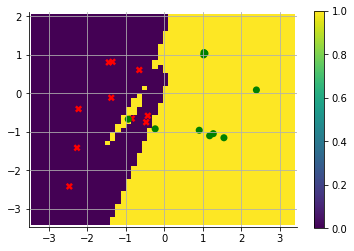

In [329]:
X, Y = hard()
nn = Sequential([Linear(2, 10), ReLU(), 
                 Linear(10, 10), ReLU(), 
                 Linear(10, 2), SoftMax()], NLL())
disp.classify(X, Y, nn, it=100000)

In [323]:
# TEST 4: try calling these methods that train with a simple dataset
def nn_tanh_test():
    np.random.seed(0)
    nn = Sequential([Linear(2, 3), Tanh(), Linear(3, 2), SoftMax()], NLL())
    X, Y = super_simple_separable()
    nn.sgd(X, Y, iters=1, lrate=0.005)
    return [np.vstack([nn.modules[0].W, nn.modules[0].W0.T]).tolist(),
            np.vstack([nn.modules[2].W, nn.modules[2].W0.T]).tolist()]


def nn_relu_test():
    np.random.seed(0)
    nn = Sequential([Linear(2, 3), ReLU(), Linear(3, 2), SoftMax()], NLL())
    X, Y = super_simple_separable()
    nn.sgd(X, Y, iters=2, lrate=0.005)
    return [np.vstack([nn.modules[0].W, nn.modules[0].W0.T]).tolist(),
            np.vstack([nn.modules[2].W, nn.modules[2].W0.T]).tolist()]


def nn_pred_test():
    np.random.seed(0)
    nn = Sequential([Linear(2, 3), ReLU(), Linear(3, 2), SoftMax()], NLL())
    X, Y = super_simple_separable()
    nn.sgd(X, Y, iters=1, lrate=0.005)
    Ypred = nn.forward(X)
    return nn.modules[-1].class_fun(Ypred).tolist(), [nn.loss.forward(Ypred, Y)]

In [324]:
nn_tanh_test()

# Expected output:
'''
[[[1.2473733761848262, 0.2829538808226157, 0.6924193292712828],
  [1.5845507770278007, 1.320562932207846, -0.6901721567010647],
  [-8.47337764291184e-12, 2.6227368810847106e-09, 0.00017353185263155828]],
 [[0.544808855557535, -0.08366117689965663],
  [-0.06331837550937104, 0.24078409926389266],
  [0.08677202043839037, 0.8360167748667923],
  [-0.0037249480614718, 0.0037249480614718]]]
'''

'\n[[[1.2473733761848262, 0.2829538808226157, 0.6924193292712828],\n  [1.5845507770278007, 1.320562932207846, -0.6901721567010647],\n  [-8.47337764291184e-12, 2.6227368810847106e-09, 0.00017353185263155828]],\n [[0.544808855557535, -0.08366117689965663],\n  [-0.06331837550937104, 0.24078409926389266],\n  [0.08677202043839037, 0.8360167748667923],\n  [-0.0037249480614718, 0.0037249480614718]]]\n'

In [325]:
nn_relu_test()

# Expected output:
'''
[[[1.2421914999646917, 0.2851239946607419, 0.6905003767490479],
  [1.5695659964519526, 1.3273884281993562, -0.6920877418422037],
  [-0.0027754917572235106, 0.001212351486908601, -0.0005239629389906042]],
 [[0.501769700845158, -0.040622022187279644],
  [-0.09260786974986723, 0.27007359350438886],
  [0.08364438851530624, 0.8391444067898763],
  [-0.004252310922204504, 0.004252310922204505]]]
'''

Iteration = 1 	Acc = 0.5 	Loss = 0.1491149875248131


'\n[[[1.2421914999646917, 0.2851239946607419, 0.6905003767490479],\n  [1.5695659964519526, 1.3273884281993562, -0.6920877418422037],\n  [-0.0027754917572235106, 0.001212351486908601, -0.0005239629389906042]],\n [[0.501769700845158, -0.040622022187279644],\n  [-0.09260786974986723, 0.27007359350438886],\n  [0.08364438851530624, 0.8391444067898763],\n  [-0.004252310922204504, 0.004252310922204505]]]\n'

In [326]:
nn_pred_test()

# Expected output:
'''
([0, 0, 0, 0], [8.56575061835767])
'''

'\n([0, 0, 0, 0], [8.56575061835767])\n'